# Análise Exploratória de dados

Artigo Original da Fonte de dados: https://www.researchgate.net/publication/338886066_Analysis_of_training_techniques_of_ANN_for_classification_of_insulators_in_electrical_power_systems 

Descrição do Projeto: "Classificador de Estado de isoladores" 

Autor: Vinicio Schmidt

Idéias futuras:
1. Remover o ruído ambiente das amostras antes de processar
2. Usar o GridSearch para otimizar os parâmetros
3. Embarcar em um RaspBerry para análise em tempo real

## Imports comuns

In [1]:
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fftshift

import struct
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt 
import matplotlib.pylab as plab

import IPython.display as ipd
import librosa
import librosa.display

%matplotlib inline

# Funções Auxiliares

In [2]:
def load_data(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [3]:
def plot_wave(caminho, titulo):    
    data, sample_rate = librosa.load(caminho)
    print("Frequência do áudio: ", sample_rate)
    librosa.display.waveplot(data,sr=sample_rate)
    plt.title(titulo)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")   
    
def plot_fft_wave(caminho, titulo, x_limits):
    data, sample_rate = librosa.load(caminho)
    n = len(data)
    T = 1/sample_rate
    yf = scipy.fft.fft(data) #Aplica a FFT no audio
    xf = np.linspace(0.0, 1.0/(2.0*T), n//2) #Cria um array contendo os pontos de x correspondentes ao yf
    
    fig, ax = plt.subplots()
    
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    ax.set_xlim(x_limits)
    plt.grid()
    plt.xlabel("Frequência")
    plt.ylabel("Magnitude")
    plt.title(titulo)
    
def plot_wave_with_fft(caminho):
    data, sample_rate = librosa.load(caminho)
    n = len(data)
    T = 1/sample_rate
    yf = scipy.fft.fft(data) #Aplica a FFT no audio
    xf = np.linspace(0.0, 1.0/(2.0*T), n//2) #Cria um array contendo os pontos de x correspondentes ao yf
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(data,sr=sample_rate)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    plt.title("Onda")
    
    plt.subplot(1, 2, 2)
    plt.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel("Frequência")
    plt.ylabel("Magnitude")
    plt.title("FFT")
    
def plot_multiple_FFT(lista_caminhos):
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.xlabel("Frequência")
    plt.ylabel("Magnitude")    
    
    for caminho in lista_caminhos:
        data, sample_rate = librosa.load(caminho)
        n = len(data)
        T = 1/sample_rate
        yf = scipy.fft.fft(data) #Aplica a FFT no audio
        xf = np.linspace(0.0, 1.0/(2.0*T), n//2) #Cria um array contendo os pontos de x correspondentes ao yf

        plt.plot(xf, 2.0/n * np.abs(yf[:n//2]))
        
def spectrograma(caminho):
    x, fs = librosa.load(caminho)
    f, t, Sxx = signal.spectrogram(x, fs)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequência [Hz]')
    plt.xlabel('Tempo [sec]')

In [4]:
def path_to_array(caminho):
    data, _ = librosa.load("Dados/" + caminho)
    return data

def chunks_fft_mean(data, n):
    yf = scipy.fft.fft(data) #Aplica a FFT no audio

    for i in range(0, len(yf), n): #Faz o chunk
        mean_value = sum(yf[i:i + n])/n #Obtem a média do chunk
        yield mean_value

# Carregamento dos dados

In [5]:
df = load_data("Dados/meta.csv")

df.head()

,Item,Arquivo,Tensão,Tipo,Condição,Variavel Sem Filtro,Variavel com Filtro,Classificador
0,1.1.01,BM_190719_115248_13384.wav,Ligado,Isolador Bom,Seco,y1,yf1,1
1,1.1.02,BM_190719_115356_13384.wav,Ligado,Isolador Bom,Seco,y2,yf2,1
2,1.1.03,BM_190719_115445_13384.wav,Ligado,Isolador Bom,Seco,y3,yf3,1
3,1.1.04,BM_190719_115605_13384.wav,Ligado,Isolador Bom,Seco,y4,yf4,1
4,1.1.05,BM_190719_115751_13384.wav,Ligado,Isolador Bom,Seco,y5,yf5,1


# EDA

In [6]:
df_eda = df.copy()

In [7]:
df_eda.describe()

,Classificador
count,120.00000
mean,5.25000
std,2.13514
min,1.00000
25%,3.75000
50%,6.50000
75%,7.00000
max,7.00000


In [8]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 8 columns):
Item                   120 non-null object
Arquivo                120 non-null object
Tensão                 120 non-null object
Tipo                   120 non-null object
Condição               120 non-null object
Variavel Sem Filtro    120 non-null object
Variavel com Filtro    120 non-null object
Classificador          120 non-null int64
dtypes: int64(1), object(7)
memory usage: 8.4+ KB


### Classificador é a coluna alvo, ou seja, a classe que o preditor deve predizer

In [9]:
df_eda["Classificador"].value_counts()

7    60
6    10
5    10
4    10
3    10
2    10
1    10
Name: Classificador, dtype: int64

In [10]:
df_eda["Tipo"].value_counts()

Isolador Bom          60
Isolador Perfurado    30
Isolador Pergurado    30
Name: Tipo, dtype: int64

In [11]:
df_classes = df[["Tipo", "Tensão", "Classificador"]].drop_duplicates()
df_classes = df_classes.reset_index(drop=True)
df_classes

,Tipo,Tensão,Classificador
0,Isolador Bom,Ligado,1
1,Isolador Bom,Ligado,2
2,Isolador Bom,Ligado,3
3,Isolador Perfurado,Ligado,4
4,Isolador Perfurado,Ligado,5
5,Isolador Perfurado,Ligado,6
6,Isolador Bom,Desligado,7
7,Isolador Pergurado,Desligado,7


# Verificar a distribuição de classes

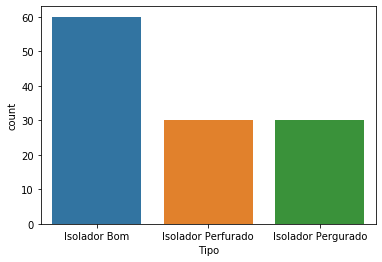

In [12]:
sns.countplot(data=df_eda, x = 'Tipo');

### O isolador Bom possui o dobro de amostras, porque?

In [13]:
filtro_bom = df_eda["Tipo"] == "Isolador Bom"
filtro_pergurado = df_eda["Tipo"] == "Isolador Pergurado"
filtro_perfurado = df_eda["Tipo"] == "Isolador Perfurado"

In [14]:
df[filtro_bom].head()

,Item,Arquivo,Tensão,Tipo,Condição,Variavel Sem Filtro,Variavel com Filtro,Classificador
0,1.1.01,BM_190719_115248_13384.wav,Ligado,Isolador Bom,Seco,y1,yf1,1
1,1.1.02,BM_190719_115356_13384.wav,Ligado,Isolador Bom,Seco,y2,yf2,1
2,1.1.03,BM_190719_115445_13384.wav,Ligado,Isolador Bom,Seco,y3,yf3,1
3,1.1.04,BM_190719_115605_13384.wav,Ligado,Isolador Bom,Seco,y4,yf4,1
4,1.1.05,BM_190719_115751_13384.wav,Ligado,Isolador Bom,Seco,y5,yf5,1


In [15]:
df[filtro_bom]["Tensão"].value_counts()

Ligado       30
Desligado    30
Name: Tensão, dtype: int64

In [16]:
df[filtro_pergurado]["Tensão"].value_counts()

Desligado    30
Name: Tensão, dtype: int64

In [17]:
df[filtro_perfurado]["Tensão"].value_counts()

Ligado    30
Name: Tensão, dtype: int64

### Existem 30 amostras ligadas e 30 desligadas, possivelmente um erro de português 

In [18]:
df[filtro_pergurado]["Classificador"].value_counts()

7    30
Name: Classificador, dtype: int64

In [19]:
df[filtro_perfurado]["Classificador"].value_counts()

6    10
5    10
4    10
Name: Classificador, dtype: int64

### Suspeita confirmada

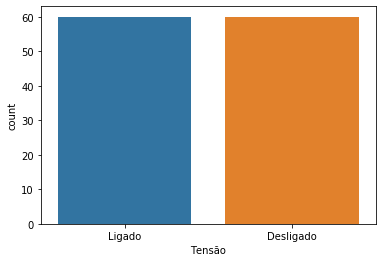

In [20]:
sns.countplot(data=df_eda, x = 'Tensão');

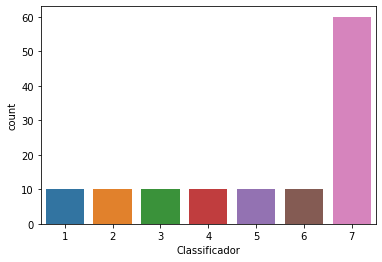

In [21]:
sns.countplot(data=df_eda, x = 'Classificador');

#### A classe 7 está claramente desbalanceada, seria interessante aplicar alguma técnica de duplicação ou redução nos dados

## Análise das formas de onda 

In [22]:
bom_seco = "Dados/BM_190719_115248_13384.wav"
bom_caolin = "Dados/BM_190719_145842_13384.wav" #Bom, Caolin
bom_caolin_791 = "Dados/BM_190719_162658_13384.wav" #Bom, caolin 7,91mS
perfurado_seco = "Dados/BM_190719_142232_13384.wav" #Perfurado Seco
perfurado_umido = "Dados/BM_190719_121256_13384.wav" #Perfurado Úmido
perfurado_caolin = "Dados/BM_190719_164340_13384.wav" #Perfurado Caolin
desligado = "Dados/BM_190719_115210_13384.wav" #Desligado

### Bom e seco

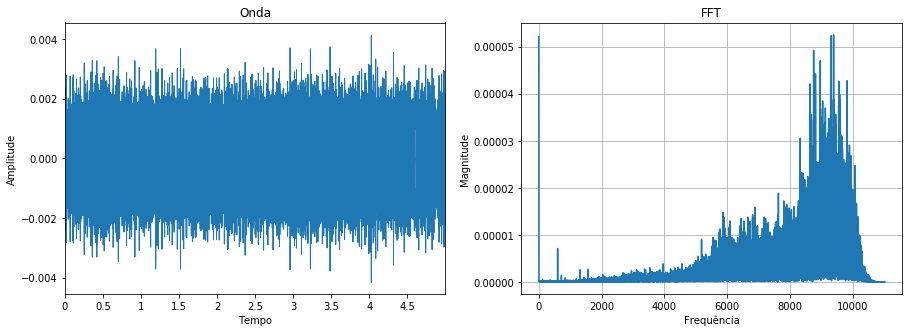

In [23]:
plot_wave_with_fft(bom_seco)

#### As ondas se concentram em frequências variando de 5000 até 10500 Hz

In [24]:
bom_seco_hz = [5000, 10000]

### Bom e Caolin

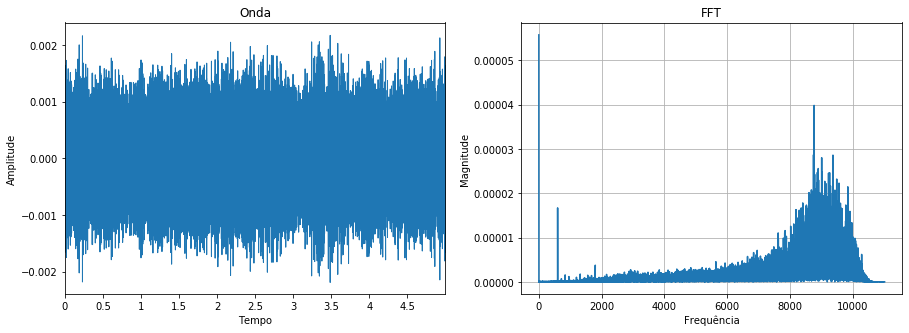

In [25]:
plot_wave_with_fft(bom_caolin)

#### As ondas se concentram em frequências variando de 8000 até 10000 Hz

In [26]:
bom_caolin_hz = [8000, 10000]

### Bom e Caolin 7,91mm

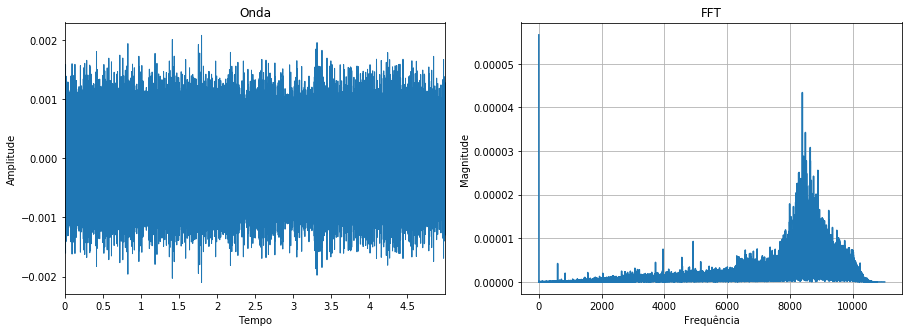

In [27]:
plot_wave_with_fft(bom_caolin_791)

#### As ondas se concentram em frequências variando de 7800 até 10000

In [28]:
bom_caolin_791_hz = [7800, 10000]

### Perfurado Seco

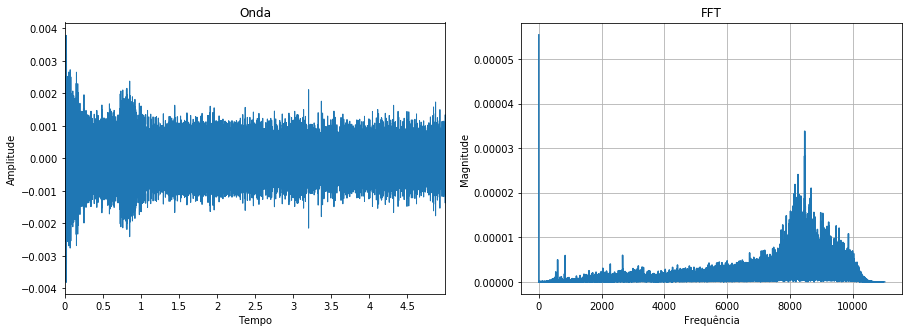

In [29]:
plot_wave_with_fft(perfurado_seco)

#### As ondas se concentram em frequências variando de 7800 até 10000

In [30]:
perfurado_seco_hz = [7800, 10000]

### Perfurado úmido

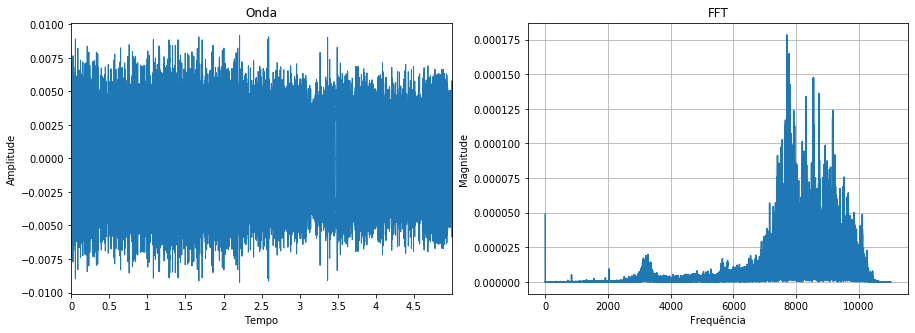

In [31]:
plot_wave_with_fft(perfurado_umido)

#### As ondas se concentram em frequências variando de 6500 e 10000

In [32]:
perfurado_umido_hz = [6500, 10000]

### Perfurado Caolin

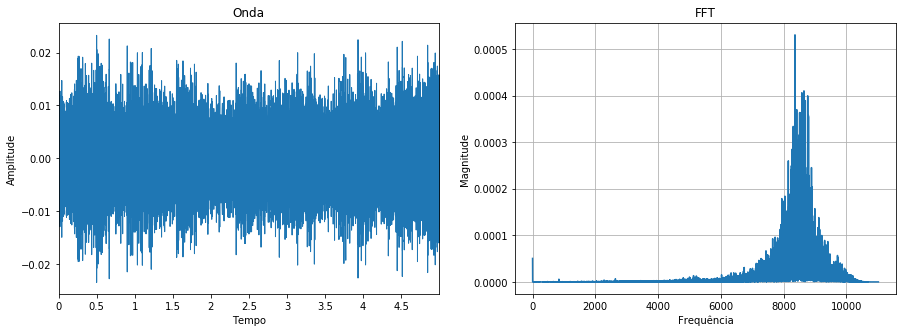

In [33]:
plot_wave_with_fft(perfurado_caolin)

#### As ondas se concentram em frequências variando de 7800 à 10000

In [34]:
perfurado_caolin_hz = [7800, 10000]

### Desligado

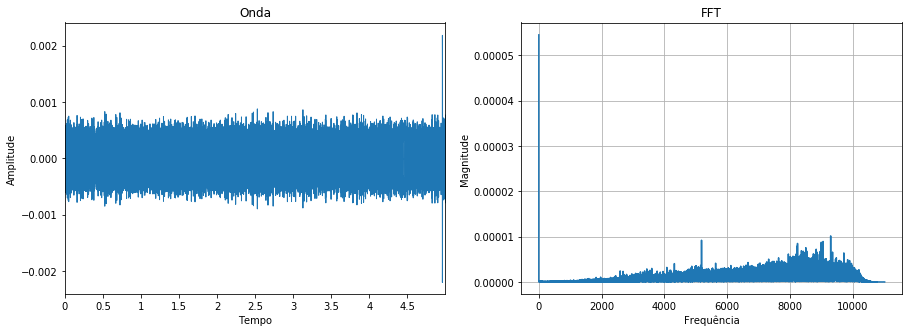

In [35]:
plot_wave_with_fft(desligado)

#### Pode-se observar um pouco de ruído

In [36]:
desligado_hz = [0, 0]

## Resumo de variação de ondas

In [37]:
frequencias = {
    "Bom Seco":bom_seco_hz,
    "Bom, Caolin":bom_caolin_hz,
    "Bom, caolin 7,91mS":bom_caolin_791_hz,
    "Perfurado Seco":perfurado_seco_hz,
    "Perfurado Úmido":perfurado_umido_hz,
    "Perfurado Caolin":perfurado_caolin_hz,
    "Desligado":desligado_hz,
}

pd.DataFrame.from_dict(frequencias, orient="index", columns=["Inicio", "Fim"])

,Inicio,Fim
Bom Seco,5000,10000
"Bom, Caolin",8000,10000
"Bom, caolin 7,91mS",7800,10000
Perfurado Seco,7800,10000
Perfurado Úmido,6500,10000
Perfurado Caolin,7800,10000
Desligado,0,0


### Existe uma pequena variação de frequências, a aplicação da FFT pode ser bem vinda  

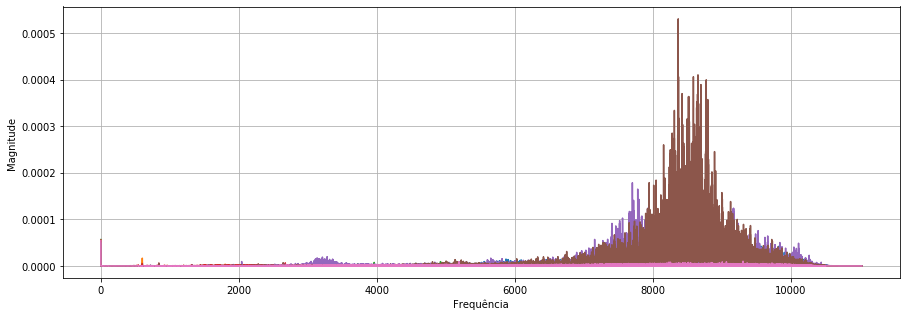

In [38]:
lista_fft = [
    bom_seco,
    bom_caolin,
    bom_caolin_791,
    perfurado_seco,
    perfurado_umido,
    perfurado_caolin,
    desligado
]

plot_multiple_FFT(lista_fft)

## Espectograma

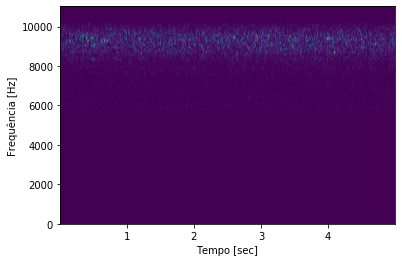

In [40]:
spectrograma(bom_seco)

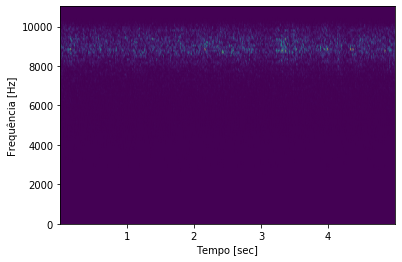

In [41]:
spectrograma(bom_caolin)

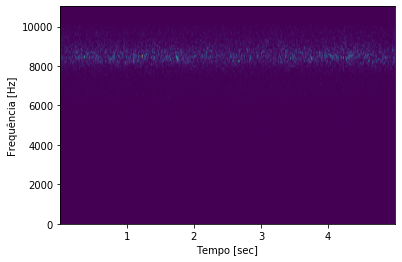

In [42]:
spectrograma(bom_caolin_791)

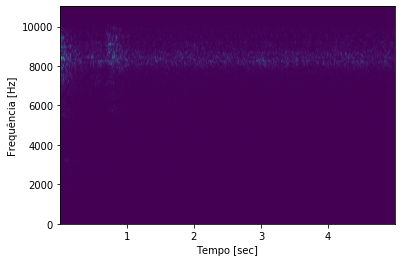

In [43]:
spectrograma(perfurado_seco)

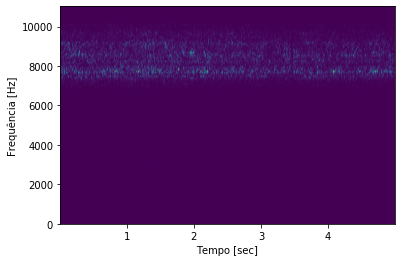

In [44]:
spectrograma(perfurado_umido)

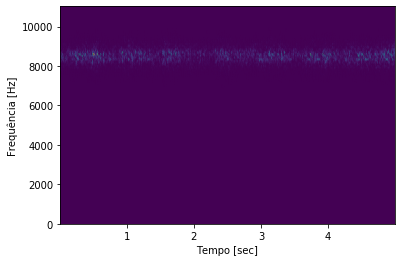

In [45]:
spectrograma(perfurado_caolin)

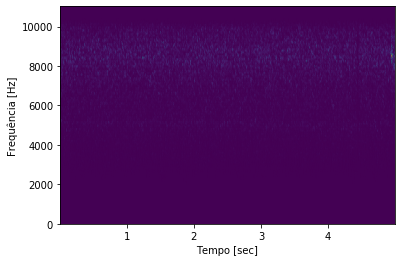

In [46]:
spectrograma(desligado)

### Pouca variação de frequência no tempo, dados temporais pouco úteis

# Preparar os dados para entrar no algoritmo

In [47]:
df_algoritmo = df.loc[:, ["Arquivo", "Classificador"]]
df_algoritmo.head()

,Arquivo,Classificador
0,BM_190719_115248_13384.wav,1
1,BM_190719_115356_13384.wav,1
2,BM_190719_115445_13384.wav,1
3,BM_190719_115605_13384.wav,1
4,BM_190719_115751_13384.wav,1


In [48]:
dict_mean_chunks = dict()
paths = df_algoritmo["Arquivo"].values

for i, path in enumerate(paths):
    print(f'Processando {i} de {len(paths)}')
    
    arr = path_to_array(path) #Obtenção do array de dados
    arr_mean = list(chunks_fft_mean(arr, 1000)) #Redução dos arrays com aplicação de FFT e média
    dict_mean_chunks[i] = arr_mean 

Processando 0 de 120
Processando 1 de 120
Processando 2 de 120
Processando 3 de 120
Processando 4 de 120
Processando 5 de 120
Processando 6 de 120
Processando 7 de 120
Processando 8 de 120
Processando 9 de 120
Processando 10 de 120
Processando 11 de 120
Processando 12 de 120
Processando 13 de 120
Processando 14 de 120
Processando 15 de 120
Processando 16 de 120
Processando 17 de 120
Processando 18 de 120
Processando 19 de 120
Processando 20 de 120
Processando 21 de 120
Processando 22 de 120
Processando 23 de 120
Processando 24 de 120
Processando 25 de 120
Processando 26 de 120
Processando 27 de 120
Processando 28 de 120
Processando 29 de 120
Processando 30 de 120
Processando 31 de 120
Processando 32 de 120
Processando 33 de 120
Processando 34 de 120
Processando 35 de 120
Processando 36 de 120
Processando 37 de 120
Processando 38 de 120
Processando 39 de 120
Processando 40 de 120
Processando 41 de 120
Processando 42 de 120
Processando 43 de 120
Processando 44 de 120
Processando 45 de 12

In [49]:
dict_mean_chunks

{0: [(0.004463283108729229-7.443845613306621e-05j),
  (0.0015552337752742461-1.8372798200289254e-05j),
  (0.0013415594329562737-0.0008544692216673867j),
  (0.0015073681778158062+0.001261877965007443j),
  (0.001485524749616161+6.471038877498358e-05j),
  (0.0017309402110986412+0.0005619790486525745j),
  (0.0013127085493179038-1.7798710614442826e-06j),
  (0.0015683463793247938+0.0004679271685890853j),
  (0.0019523720303550364+0.0009652832783758641j),
  (0.0012922587734647095+0.0009070987026207149j),
  (0.0011932766526006162+0.0003693021127255634j),
  (0.00169881395669654+0.0011444359198212624j),
  (0.0022093397718854248+0.0015243023000657558j),
  (0.0010670197485014795+0.0010983910099603236j),
  (0.0015302272732369603+0.00089800680661574j),
  (0.0014251749699469656-0.00040201058285310867j),
  (0.003196581860800507+0.0007407251461409032j),
  (0.0011253784617874772-0.00028582557057961824j),
  (0.0018080656146630646+0.001113239596830681j),
  (0.0014148329503368587-0.0005870329500176013j),
  

In [50]:
df_mean_chunks = pd.DataFrame.from_dict(dict_mean_chunks, orient="index")
df_mean_chunks.head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,0.004463-0.000074j,0.001555-0.000018j,0.001342-0.000854j,0.001507+0.001262j,0.001486+0.000065j,0.001731+0.000562j,0.001313-0.000002j,0.001568+0.000468j,0.001952+0.000965j,0.001292+0.000907j,...,0.001712-0.000308j,0.001877-0.000777j,0.001231-0.000110j,0.001752-0.000430j,0.001492-0.000233j,0.001440-0.000341j,0.001364-0.000039j,0.001525+0.000052j,0.001572-0.000018j,0.000409+0.000072j
1,0.002043-0.000037j,-0.000794-0.000005j,-0.000644-0.000054j,-0.000830+0.000606j,-0.000719-0.000274j,-0.000823+0.000080j,-0.000854+0.000123j,-0.000452+0.000056j,-0.000661+0.000105j,-0.001026-0.000973j,...,-0.000815+0.000084j,-0.000225+0.000087j,-0.000943-0.000107j,-0.000848-0.000111j,-0.000625-0.000023j,-0.000830-0.000204j,-0.000734-0.000145j,-0.000767+0.000001j,-0.000795-0.000020j,-0.000229+0.000036j
2,0.002743+0.000064j,-0.000130+0.000007j,0.000116+0.000019j,-0.000334+0.000087j,-0.000277+0.000257j,0.000174+0.000211j,-0.000259+0.000064j,-0.000223+0.000218j,-0.000449-0.000196j,-0.000429+0.000594j,...,-0.000473+0.000274j,-0.000373-0.000514j,-0.000135-0.000022j,-0.000099-0.000127j,-0.000157-0.000198j,-0.000412-0.000133j,0.000227-0.000045j,-0.000144-0.000041j,-0.000149+0.000020j,-0.000050-0.000069j
3,0.002637+0.000008j,-0.000303+0.000024j,-0.000128+0.000209j,-0.000044+0.000013j,-0.000455-0.000113j,-0.000283-0.000123j,-0.000563-0.000215j,0.000127-0.000182j,-0.000328-0.000921j,-0.000726-0.000418j,...,-0.000741+0.000702j,0.000298+0.000570j,-0.000367-0.000022j,-0.000358+0.000112j,-0.000470+0.000111j,-0.000112+0.000090j,-0.000110-0.000297j,-0.000267+0.000030j,-0.000180-0.000019j,-0.000126-0.000004j
4,0.002398+0.000046j,-0.000430+0.000002j,-0.000507-0.000214j,-0.000497+0.000017j,-0.000217-0.000134j,-0.000235-0.000089j,-0.000553+0.000392j,-0.000444+0.000046j,-0.000323-0.000252j,-0.000139+0.000189j,...,-0.000649+0.000392j,0.000007-0.000053j,-0.000690-0.000514j,-0.000401+0.000054j,-0.000343+0.000043j,-0.000343+0.000064j,-0.000480+0.000130j,-0.000467+0.000017j,-0.000453-0.000027j,-0.000145+0.000004j


## Separação da parte real e imaginária

In [77]:
df_algoritmo_tratado = df_mean_chunks.copy()
for coluna in df_algoritmo_tratado.columns:
    df_algoritmo_tratado[str(coluna)+"-R"] = df_test[coluna].to_numpy().real
    df_algoritmo_tratado[str(coluna)+"-I"] = df_test[coluna].to_numpy().imag
    
df_algoritmo_tratado = df_algoritmo_tratado.drop(df_mean_chunks.columns, axis=1)

In [78]:
df_algoritmo_tratado.head()

,0-R,0-I,1-R,1-I,2-R,2-I,3-R,3-I,4-R,4-I,...,106-R,106-I,107-R,107-I,108-R,108-I,109-R,109-I,110-R,110-I
0,0.004463,-0.000074,0.001555,-0.000018,0.001342,-0.000854,0.001507,0.001262,0.001486,0.000065,...,0.001440,-0.000341,0.001364,-0.000039,0.001525,0.000052,0.001572,-0.000018,0.000409,0.000072
1,0.002043,-0.000037,-0.000794,-0.000005,-0.000644,-0.000054,-0.000830,0.000606,-0.000719,-0.000274,...,-0.000830,-0.000204,-0.000734,-0.000145,-0.000767,0.000001,-0.000795,-0.000020,-0.000229,0.000036
2,0.002743,0.000064,-0.000130,0.000007,0.000116,0.000019,-0.000334,0.000087,-0.000277,0.000257,...,-0.000412,-0.000133,0.000227,-0.000045,-0.000144,-0.000041,-0.000149,0.000020,-0.000050,-0.000069
3,0.002637,0.000008,-0.000303,0.000024,-0.000128,0.000209,-0.000044,0.000013,-0.000455,-0.000113,...,-0.000112,0.000090,-0.000110,-0.000297,-0.000267,0.000030,-0.000180,-0.000019,-0.000126,-0.000004
4,0.002398,0.000046,-0.000430,0.000002,-0.000507,-0.000214,-0.000497,0.000017,-0.000217,-0.000134,...,-0.000343,0.000064,-0.000480,0.000130,-0.000467,0.000017,-0.000453,-0.000027,-0.000145,0.000004


In [79]:
df_algoritmo_tratado = df_algoritmo_tratado.join(df_algoritmo["Classificador"])
df_algoritmo_tratado.head()

,0-R,0-I,1-R,1-I,2-R,2-I,3-R,3-I,4-R,4-I,...,106-I,107-R,107-I,108-R,108-I,109-R,109-I,110-R,110-I,Classificador
0,0.004463,-0.000074,0.001555,-0.000018,0.001342,-0.000854,0.001507,0.001262,0.001486,0.000065,...,-0.000341,0.001364,-0.000039,0.001525,0.000052,0.001572,-0.000018,0.000409,0.000072,1
1,0.002043,-0.000037,-0.000794,-0.000005,-0.000644,-0.000054,-0.000830,0.000606,-0.000719,-0.000274,...,-0.000204,-0.000734,-0.000145,-0.000767,0.000001,-0.000795,-0.000020,-0.000229,0.000036,1
2,0.002743,0.000064,-0.000130,0.000007,0.000116,0.000019,-0.000334,0.000087,-0.000277,0.000257,...,-0.000133,0.000227,-0.000045,-0.000144,-0.000041,-0.000149,0.000020,-0.000050,-0.000069,1
3,0.002637,0.000008,-0.000303,0.000024,-0.000128,0.000209,-0.000044,0.000013,-0.000455,-0.000113,...,0.000090,-0.000110,-0.000297,-0.000267,0.000030,-0.000180,-0.000019,-0.000126,-0.000004,1
4,0.002398,0.000046,-0.000430,0.000002,-0.000507,-0.000214,-0.000497,0.000017,-0.000217,-0.000134,...,0.000064,-0.000480,0.000130,-0.000467,0.000017,-0.000453,-0.000027,-0.000145,0.000004,1


### Resolver o desbalanceamento de classes

In [80]:
from sklearn.utils import shuffle

# obter tudo que for diferente da classe 7
filtro = df_algoritmo_tratado["Classificador"]==7

# gerar 6 vezes mais amostras
df_paste_tratado = df_algoritmo_tratado.copy()
df_pasting = df_algoritmo_tratado[~filtro].copy()

for i in range(5):
    df_paste_tratado = pd.concat([df_paste_tratado, df_pasting], ignore_index=True)

#Embaralhar o conjunto
df_paste_tratado = shuffle(df_paste_tratado)
df_paste_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 89 to 401
Columns: 223 entries, 0-R to Classificador
dtypes: float64(222), int64(1)
memory usage: 735.0 KB


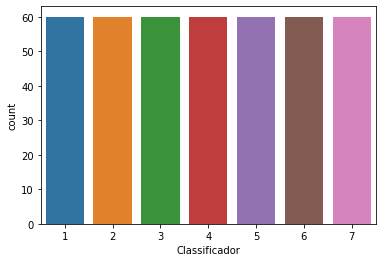

In [81]:
sns.countplot(data=df_paste_tratado, x = 'Classificador');

## Separação treino teste

In [82]:
X = df_paste_tratado.drop(["Classificador"], axis=1)
X

,0-R,0-I,1-R,1-I,2-R,2-I,3-R,3-I,4-R,4-I,...,106-R,106-I,107-R,107-I,108-R,108-I,109-R,109-I,110-R,110-I
89,0.003360,0.000009,0.000193,0.000091,0.000341,0.000091,0.000078,-0.000174,0.000149,0.000071,...,0.000037,0.000070,0.000284,-0.000097,0.000295,-0.000049,0.000183,-0.000032,0.000047,0.000007
63,0.002841,-0.000022,-0.000069,-0.000062,-0.000215,-0.000226,-0.000033,0.000043,-0.000286,-0.000041,...,-0.000136,-0.000043,-0.000146,0.000243,-0.000114,0.000059,-0.000172,0.000081,-0.000045,-0.000030
45,0.003235,0.000134,0.000257,0.000118,0.000331,-0.000445,-0.000329,0.000414,0.000836,-0.000804,...,0.000478,-0.000639,-0.000102,0.000590,0.000270,-0.000252,0.000415,-0.000054,0.000116,-0.000092
375,0.002784,0.000072,-0.000216,-0.000039,-0.000067,0.000513,-0.000282,0.000246,-0.000201,-0.000101,...,-0.000557,0.000147,0.000201,-0.000704,-0.000224,0.000073,-0.000301,-0.000113,-0.000067,0.000012
292,0.006236,0.000037,0.003538,-0.000052,0.003551,0.000047,0.003409,0.000069,0.003720,0.000213,...,0.003806,-0.000203,0.003451,0.000008,0.003546,-0.000029,0.003504,0.000013,0.000822,-0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.003468,0.000031,0.000375,0.000027,0.001117,0.001032,-0.001286,-0.001533,0.000272,-0.000277,...,0.000211,0.000022,-0.000386,0.000500,0.000366,0.000022,0.000396,-0.000035,0.000089,-0.000014
313,0.003836,0.000067,0.000632,-0.000028,0.000259,-0.000018,0.000550,-0.000065,0.000555,0.000105,...,0.000677,0.000026,0.000106,0.000041,0.000618,0.000071,0.000701,-0.000026,0.000179,-0.000057
413,0.007894,0.000108,0.005062,-0.000002,0.004927,-0.000705,0.005175,0.000884,0.004943,0.000271,...,0.005158,-0.000203,0.005020,-0.000062,0.005170,0.000041,0.005080,-0.000130,0.001241,0.000019
27,0.003217,-0.000014,0.000145,-0.000098,0.000475,-0.000333,0.000204,0.000182,0.000036,-0.000148,...,0.000178,0.000153,0.000363,0.000105,0.000237,0.000094,0.000104,-0.000011,0.000039,0.000037


In [83]:
y = df_paste_tratado["Classificador"]
y

89     7
63     7
45     5
375    2
292    6
      ..
259    2
313    2
413    6
27     3
401    5
Name: Classificador, Length: 420, dtype: int64

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Experimentação de Modelos

In [85]:
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=100)

clf_rnd.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True, gamma="auto"),
    NuSVC(probability=True, gamma="auto"),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

for classifier in classifiers:
    classifier.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % classifier.score(X_test, y_test))
    print("\n")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 1.000


SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.103


NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
model score: 0.540


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
 

### Vantagem clara dos algoritmos baseados em instância frente aos algoritmos baseados em modelo

## Teste e apresentação dos resultados

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

predicoes = clf_rnd.predict(X_test)

In [87]:
accuracy_score(predicoes, y_test)

1.0

In [88]:
confusion_matrix(predicoes, y_test)

array([[18,  0,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  0],
       [ 0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0, 18]], dtype=int64)

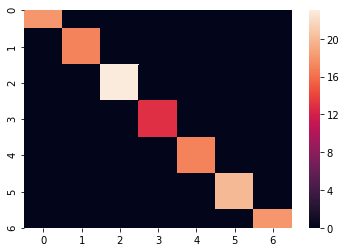

In [89]:
sns.heatmap(confusion_matrix(predicoes, y_test));

In [90]:
print(classification_report(predicoes,y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        18

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [91]:
clf_rep = classification_report(predicoes,y_test, output_dict=True)
classes = df_classes["Classificador"].unique()


clf_rep_list = [clf_rep[str(x)] for x in classes]
clf_rep_list.append(clf_rep['7'])
clf_rep_list

[{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 20},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18},
 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18}]

In [92]:
df_report = pd.DataFrame.from_dict(clf_rep_list)
df_report

,precision,recall,f1-score,support
0,1.0,1.0,1.0,18
1,1.0,1.0,1.0,17
2,1.0,1.0,1.0,23
3,1.0,1.0,1.0,13
4,1.0,1.0,1.0,17
5,1.0,1.0,1.0,20
6,1.0,1.0,1.0,18
7,1.0,1.0,1.0,18


In [93]:
df_classes.join(df_report)

,Tipo,Tensão,Classificador,precision,recall,f1-score,support
0,Isolador Bom,Ligado,1,1.0,1.0,1.0,18
1,Isolador Bom,Ligado,2,1.0,1.0,1.0,17
2,Isolador Bom,Ligado,3,1.0,1.0,1.0,23
3,Isolador Perfurado,Ligado,4,1.0,1.0,1.0,13
4,Isolador Perfurado,Ligado,5,1.0,1.0,1.0,17
5,Isolador Perfurado,Ligado,6,1.0,1.0,1.0,20
6,Isolador Bom,Desligado,7,1.0,1.0,1.0,18
7,Isolador Pergurado,Desligado,7,1.0,1.0,1.0,18
